Use a specialised kernel function to incoporate physical models into the GP. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W, phys_kernel
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [4]:
len(pch)

23

In [5]:
def convert_to_lin(x):
    return 10**(x/10)
def convert_to_db(x):
    return 10*np.log10(x)
def convert_snr_to_nsr(x):
    return convert_to_db([1/convert_to_lin(i) for i in snr])

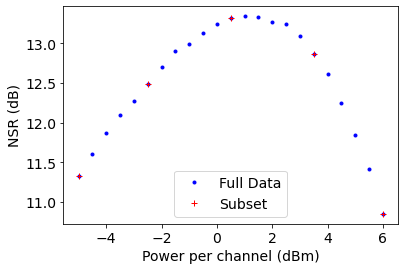

In [6]:
snr_sub = np.array([snr[0], snr[5], snr[11], snr[17], snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[11], pch[17], pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("NSR (dB)")
plt.legend()
plt.show()

In [7]:
def shift_pch(pch, emp_pk):
    pch_gn = np.linspace(pch[0], pch[-1], 100)
    pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
    print("Power shift: %.3f" % (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))]))
    return pch_shifted
def gen_phys_targets(model, pch, num_pts_phys):
    pch_gn_shifted = np.linspace(pch[0], pch[-1], num_pts_phys)
    snr_phys = (model.predict_snr(pch_gn_shifted)).reshape(-1,1)
    return pch_gn_shifted, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR mean [dB],  TRx back to back SNR standard dev. [dB], random seed

In [8]:
unc_fac = 0.01
trxbtb = 15
nsr_std = convert_to_db(unc_fac*convert_to_lin(-trxbtb))

In [9]:
phys_model = GN_model(100, 1550, 1, 0.72, 18, 0.18, 35, 40.2, 50, 4.6, 10, -15, nsr_std, 4)

In [10]:
pch_shifted = shift_pch(pch, 0.7)

Power shift: 1.033


In [11]:
b = phys_model.calc_eta(pch)
a = phys_model.calc_Pase()
print(a)
print(b)

9.231884329878952e-06
[5229.32948902 5229.32948902 5229.32948902 5229.32948902 5229.32948902
 5229.32948902 5229.32948902 5229.32948902 5229.32948902 5229.32948902
 5229.32948902 5229.32948902 5229.32948902 5229.32948902 5229.32948902
 5229.32948902 5229.32948902 5229.32948902 5229.32948902 5229.32948902
 5229.32948902 5229.32948902 5229.32948902]


Check the values of a and b by generating the predicted SNR at 0 dBm with TRx b2b = 15 dB:

In [12]:
convert_to_db( (1/(1e-3/(a+b*(1e-3)**3)) + 1/convert_to_lin(15) )**(-1) )

array([13.36449922, 13.36449922, 13.36449922, 13.36449922, 13.36449922,
       13.36449922, 13.36449922, 13.36449922, 13.36449922, 13.36449922,
       13.36449922, 13.36449922, 13.36449922, 13.36449922, 13.36449922,
       13.36449922, 13.36449922, 13.36449922, 13.36449922, 13.36449922,
       13.36449922, 13.36449922, 13.36449922])

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [13]:
kernel_phys = C(1, (1e-5, 1e5)) * phys_kernel(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))

In [14]:
nsr = convert_snr_to_nsr(snr)

In [15]:
nsr_lin = convert_to_lin(nsr)
pch_lin = convert_to_lin(pch)
pch_shifted_lin = convert_to_lin(pch_shifted)

In [16]:
def train_phys_kernel_gp(pch, nsr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    nsr = nsr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_phys = C(1, (1e-5, 1e5)) * phys_kernel(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_phys, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, nsr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml

In [17]:
mu_sk_f, std_sk_f, theta_f, lml_f = train_phys_kernel_gp(pch_shifted_lin, nsr, pch)
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 

/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/kernels.py:1682: RuntimeWarning: divide by zero encountered in true_divide
  return a/X + b*np.multiply(X, X)


Confused by this warning as all input power values are above 0...

In [18]:
pch_lin > 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

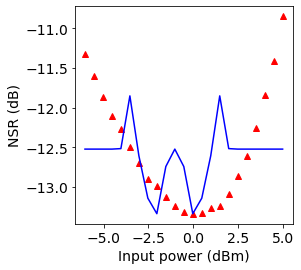

In [19]:
f, ax = plt.subplots()
ax.plot(pch_shifted, nsr, 'r^')
ax.plot(pch_shifted, mu_sk_f, 'b-')
plt.xlabel("Input power (dBm)")
plt.ylabel("NSR (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/custom_kernel_result_element.pdf', dpi=200,bbox_inches='tight')
plt.show()